In [2]:
pip install torchvision

  Using cached torchvision-0.15.2-cp39-cp39-win_amd64.whl (1.2 MB)
     -------------------------------------- 172.4/172.4 MB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['Acne_Rosacea','Actinic','Atopic_Dermatitis']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [8]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [5]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [5]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [6]:
# Setup directory paths to train and test images
train_dir = 'D:/SIH 2023/Image-Classification-Using-Vision-transformer-main/Dataset/train'
test_dir = 'D:/SIH 2023/Image-Classification-Using-Vision-transformer-main/Dataset/test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [7]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [8]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [9]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [9]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7939 | train_acc: 0.6644 | test_loss: 1.1398 | test_acc: 0.4934
Epoch: 2 | train_loss: 0.5120 | train_acc: 0.8139 | test_loss: 1.2666 | test_acc: 0.5164
Epoch: 3 | train_loss: 0.4005 | train_acc: 0.8519 | test_loss: 1.2177 | test_acc: 0.5164
Epoch: 4 | train_loss: 0.3464 | train_acc: 0.8954 | test_loss: 1.2896 | test_acc: 0.5164
Epoch: 5 | train_loss: 0.3128 | train_acc: 0.9022 | test_loss: 1.3189 | test_acc: 0.5148
Epoch: 6 | train_loss: 0.2925 | train_acc: 0.9158 | test_loss: 1.4054 | test_acc: 0.5230
Epoch: 7 | train_loss: 0.2687 | train_acc: 0.9253 | test_loss: 1.3689 | test_acc: 0.5263
Epoch: 8 | train_loss: 0.2490 | train_acc: 0.9321 | test_loss: 1.4173 | test_acc: 0.5247
Epoch: 9 | train_loss: 0.2292 | train_acc: 0.9307 | test_loss: 1.4487 | test_acc: 0.5263
Epoch: 10 | train_loss: 0.2313 | train_acc: 0.9416 | test_loss: 1.4472 | test_acc: 0.5263


# pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

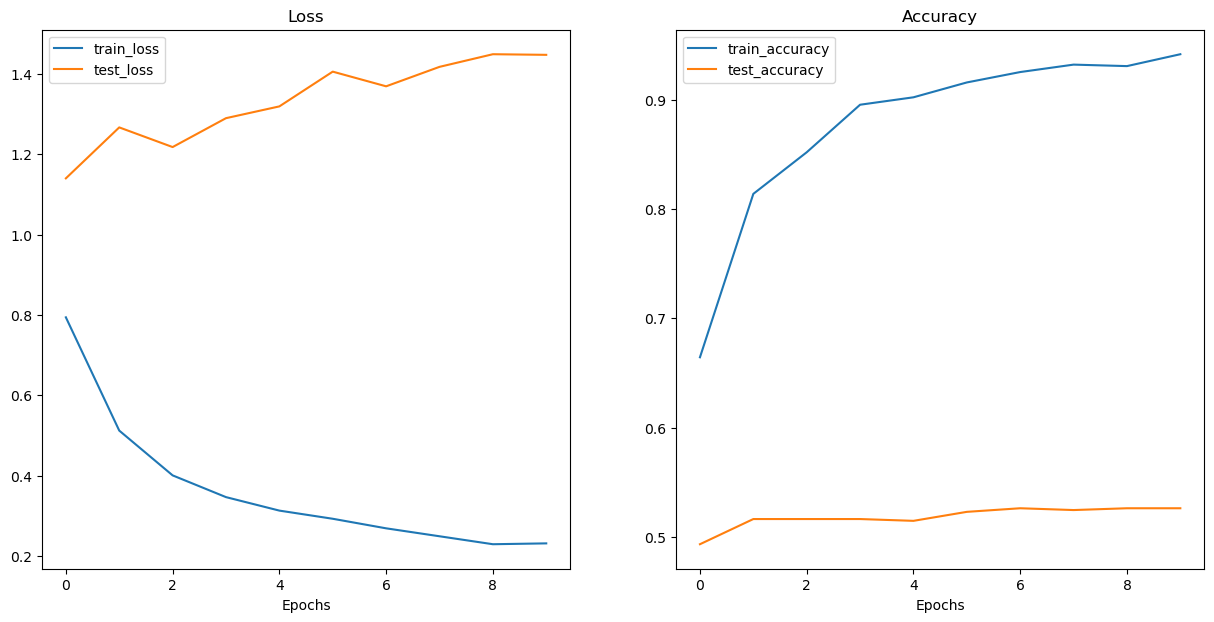

In [10]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

# Let's make Prediction:

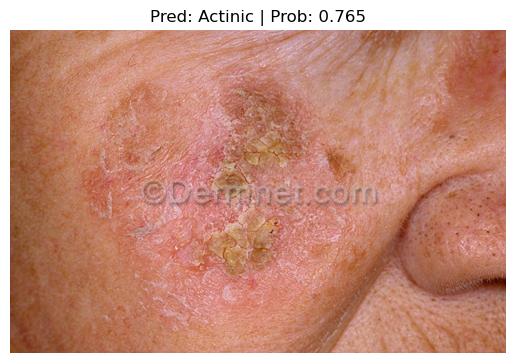

In [11]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "actinic-keratosis-face-9.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

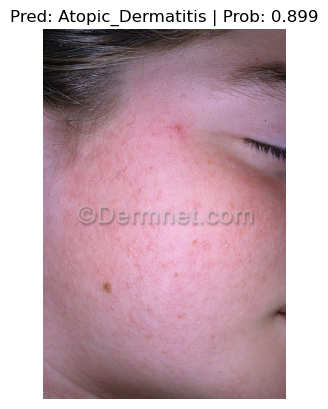

In [12]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "4th1IMG008.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [19]:
pip install Flask

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install -U flask-cors

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from going_modular.going_modular.predictions import pred_and_plot_image
from flask import Flask, jsonify, render_template, request
from flask_cors import CORS
from PIL import Image
import io

app = Flask(_name_)
CORS(app)

@app.route('/')
def hello_worlds():
    return 'Hello, cgu!'

@app.route('/about')
def about():
    return 'This is the about page!'

@app.route('/upload-image', methods=['POST'])
def upload_image():
    try:
        image_file = request.files['image']
        if image_file:
            # Read the uploaded image
            image_data = image_file.read()

#             # Open the image using Pillow
            image = Image.open(io.BytesIO(image_data))

#             # Save the image as JPG (you can specify the path and filename)
            image.save("uploaded_image.jpg", "JPEG")
            
            custom_image_path = "uploaded_image.jpg"
            
            
            pred_and_plot_image(model=pretrained_vit, image_path=custom_image_path,class_names=class_names)


            buffer = io.BytesIO()
            plt.savefig(buffer, format='png')
            buffer.seek(0)

            image_data = buffer.read()
    
            return Response(image_data, content_type='image/png')

            
#             return "Image received and saved as uploaded_image.jpg successfully"
#             return result
        else:
            return "No image file provided", 400
        return "Image received successfully"
    except Exception as e:
        return str(e), 400

if name == '_main_':
    app.run()

In [ ]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "uploaded_image.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)